# Data Visualisation Notebook

## Objectives

- Answer business requirement 2 :
The client is interested in predicting if a cherry tree is healthy or contains powdery mildew.

## Inputs
- inputs/cherry-leaves/cherry-leaves/test
- inputs/cherry-leaves/cherry-leaves/train
- inputs/cherry-leaves/cherry-leaves/validation
- image shape embeddings

## Outputs
- Images distribution plot in train, validation and test set
- Image augmentation
- Class indices to change prediction inference in labels
- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file

## Additional Comments / Insights/ Conclusions
None

## Importing regular packages

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Setting Working Directory


In [7]:
cwd= os.getcwd()


In [8]:
os.chdir('/workspace/MildewDetectionApp')
print("You set a new current directory")

You set a new current directory


In [9]:
work_dir = os.getcwd()
work_dir

'/workspace/MildewDetectionApp'

## Setting up Input Directories

In [10]:
my_data_dir = 'inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Setting output Directories

In [11]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Setting Label Names

In [12]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


## Setting Image Shape

In [13]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




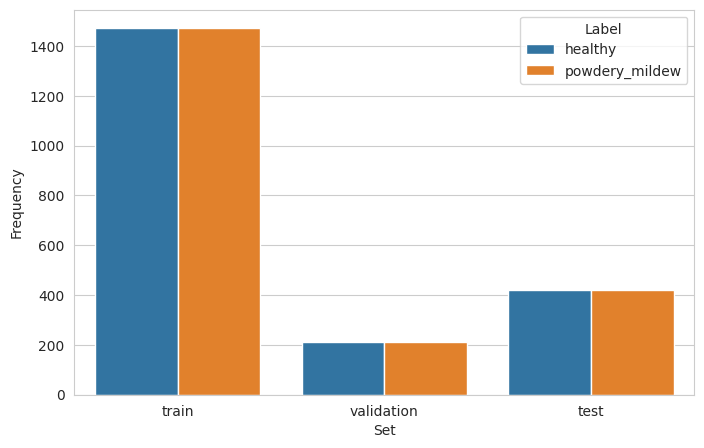

In [14]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## Image data augmentation
ImageDataGenerator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Configuring ImageDataGenerator

In [16]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Augmentation of training image dataset

In [17]:
batch_size = 20 # Setting batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augmentation of validation image dataset

In [18]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augmentation of test image dataset

In [19]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plotting augmented training image

(20, 256, 256, 3)


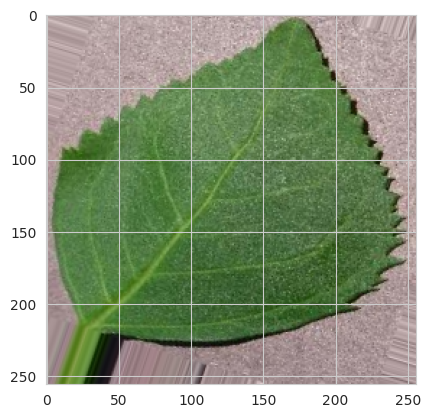

(20, 256, 256, 3)


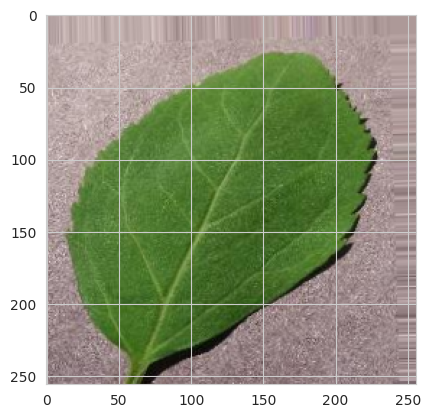

(20, 256, 256, 3)


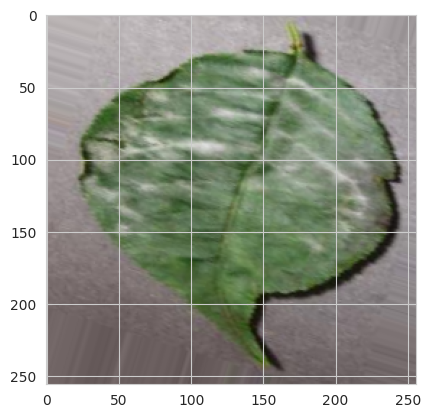

In [20]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plotting augmented validation and test images

(20, 256, 256, 3)


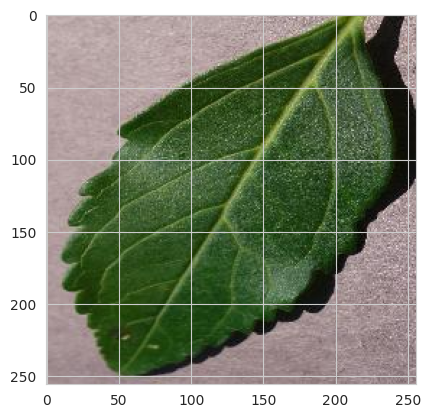

(20, 256, 256, 3)


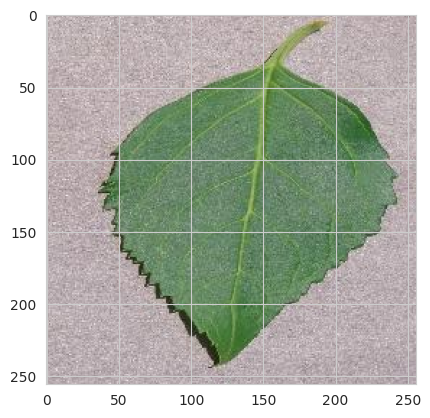

(20, 256, 256, 3)


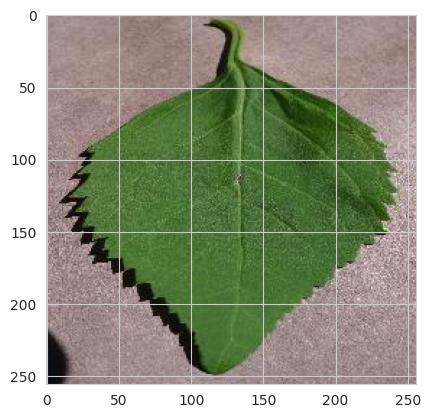

In [21]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


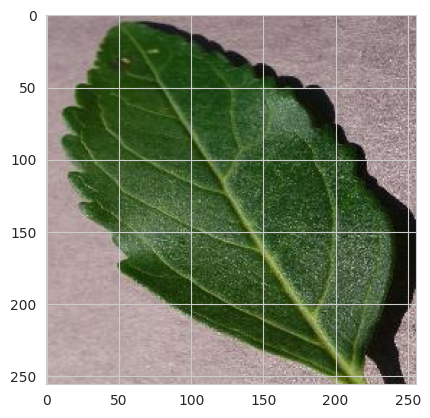

(20, 256, 256, 3)


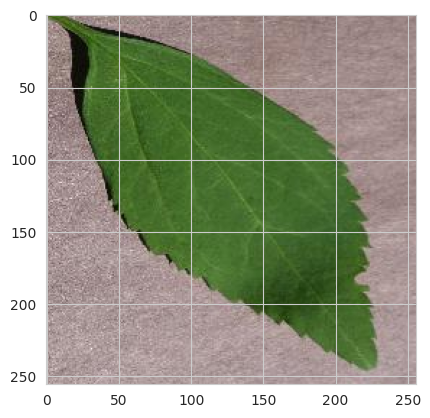

(20, 256, 256, 3)


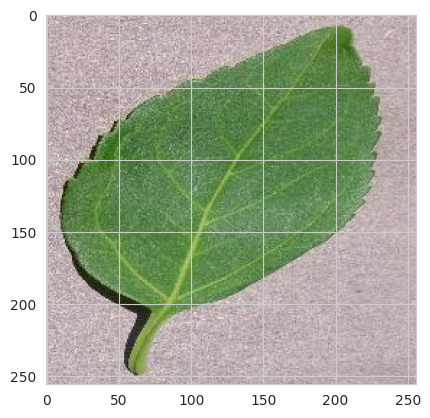

In [22]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Saving class_indices

In [23]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

# Model creation

## Importing model packages


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D


## Model

In [25]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

## Model Summary

In [26]:
create_tf_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)            

## Early stopping

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

## Fitting model for model training

In [28]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2022-12-28 15:49:29.536962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-12-28 15:49:30.480373: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.
2022-12-28 15:49:32.183439: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.


  1/147 [..............................] - ETA: 7:25 - loss: 0.7069 - accuracy: 0.3500

2022-12-28 15:49:32.614740: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.
2022-12-28 15:49:34.195780: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.


  2/147 [..............................] - ETA: 4:50 - loss: 1.1573 - accuracy: 0.4750

2022-12-28 15:49:34.616526: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.


147/147 [==============================] - 171s 1s/step - loss: 0.3498 - accuracy: 0.8269 - val_loss: 0.1446 - val_accuracy: 0.9690
Epoch 2/25
147/147 [==============================] - 193s 1s/step - loss: 0.0680 - accuracy: 0.9812 - val_loss: 0.5668 - val_accuracy: 0.8905
Epoch 3/25
147/147 [==============================] - 188s 1s/step - loss: 0.0828 - accuracy: 0.9750 - val_loss: 0.0158 - val_accuracy: 0.9952
Epoch 4/25
147/147 [==============================] - 197s 1s/step - loss: 0.0231 - accuracy: 0.9935 - val_loss: 0.1941 - val_accuracy: 0.9762
Epoch 5/25
147/147 [==============================] - 173s 1s/step - loss: 0.0611 - accuracy: 0.9788 - val_loss: 0.0351 - val_accuracy: 0.9905
Epoch 6/25
147/147 [==============================] - 217s 1s/step - loss: 0.0189 - accuracy: 0.9966 - val_loss: 0.1463 - val_accuracy: 0.9524


## Saving Model

In [29]:
model.save('outputs/v1/MildewDetectionApp_model.h5')

# Model Performace
## Model learning curve

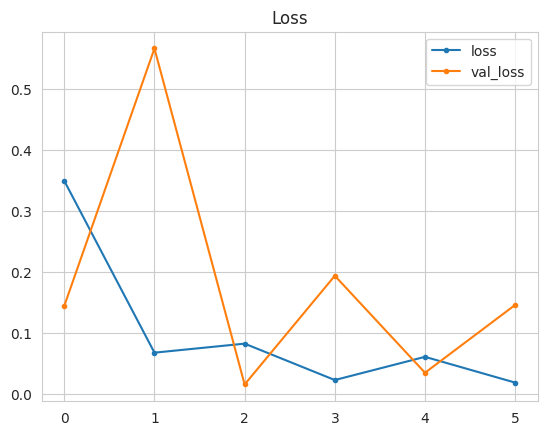

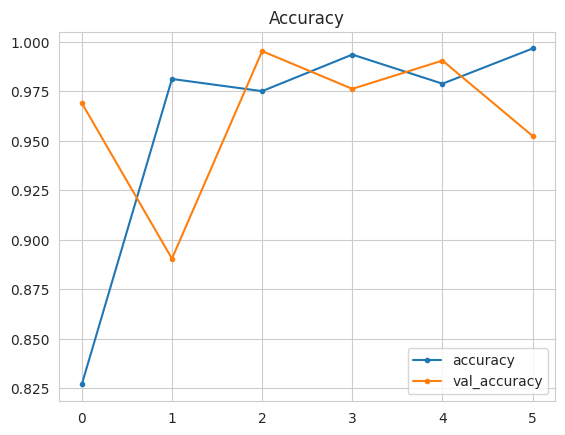

In [30]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation
Loading saved model

In [31]:
from keras.models import load_model
model = load_model('outputs/v1/MildewDetectionApp_model.h5')

## Evaluating model on test set

In [32]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 10s 240ms/step - loss: 0.1560 - accuracy: 0.9491


## Saved evaluation pickle

In [33]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data
Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


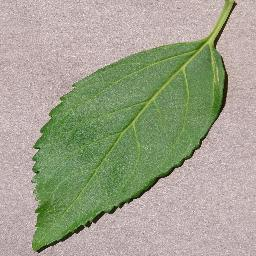

In [46]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0]

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

## Converting image to array and prepare for prediction

In [47]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/257
print(my_image.shape)

(1, 256, 256, 3)


## Predicting class probabilities

In [48]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999999999762599
healthy


## Pushing files to Repo

In [49]:
!cat .gitignore

inputs/cherry-leaves/cherry-leaves/test
inputs/cherry-leaves/cherry-leaves/train
kaggle.json
*.ipynb
__pycache__/




In [50]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .gitignore
	modified:   README.md
	modified:   app.py
	modified:   app_pages/__pycache__/multipage.cpython-38.pyc
	modified:   app_pages/__pycache__/page_ml_performance.cpython-38.pyc
	modified:   app_pages/__pycache__/page_project_hypothesis.cpython-38.pyc
	modified:   app_pages/__pycache__/page_summary.cpython-38.pyc
	modified:   app_pages/multipage.py
	deleted:    app_pages/page_cells_visualizer.py
	deleted:    app_pages/page_malaria_detector.py
	modified:   app_pages/page_ml_performance.py
	modified:   app_pages/page_project_hypothesis.py
	modified:   app_pages/page_summary.py
	modified:   jupyter_notebooks/03 - Modelling and Evaluating.ipynb
	modified:   src/__pycache__/data_management.cpython-38.pyc
	modified:   src/machine_learning/__pycache

In [41]:
!git add .


In [42]:
!git commit -am " Add new plots"

[main af06fdc4]  Add new plots
 434 files changed, 1553 insertions(+), 1382 deletions(-)
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092_flipTB.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/02a7466b-4847-4a18-bbd9-f0278e7b8d20___JR_HL 9582.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/0438b691-45f8-4251-83bd-8344656716a1___JR_HL 4152_180deg.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/048daa26-d38c-477a-96b8-018b3d4ba386___JR_HL 9767_180deg.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/0580bdc7-e60e-4ba9-87dc-1202e57b94aa___JR_HL 4159.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/069996a8-8cdb-4837-a5fe-c5a957b5677a___JR_HL 3938.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/077273c0-4325-45d9-995e-20b060eab6bf___JR_HL 949

In [43]:
!git push

Enumerating objects: 451, done.
Counting objects: 100% (451/451), done.
Delta compression using up to 16 threads
Compressing objects: 100% (438/438), done.
Writing objects: 100% (445/445), 82.18 MiB | 8.79 MiB/s, done.
Total 445 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: warning: See http://git.io/iEPt8g for more information.
remote: warning: File outputs/v1/MildewDetectionApp_model.h5 is 85.07 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/Vannesha2021/MildewDetectionApp.git
   a4f7e832..af06fdc4  main -> main
